$$\bigtriangledown ^2 u(x,y)=f(x,y) \text{ in } \Omega=[0,1]\times [0,1]$$
$$f(x,y)=2\pi^2 \sin (\pi x)\sin (\pi y)$$
$$u(x,y)=0 \text{ on } \partial \Omega$$
The analytic solution is $u(x,y)=2\pi^2 \sin(\pi x)\sin(\pi y)$

Epoch 0, Loss: 9.4479e+01
Epoch 1000, Loss: 2.5798e+00
Epoch 2000, Loss: 1.0693e-01
Epoch 3000, Loss: 5.6807e-02
Epoch 4000, Loss: 2.8454e-02
Epoch 5000, Loss: 1.6675e-02
Epoch 6000, Loss: 1.5752e-02
Epoch 7000, Loss: 1.4158e-02
Epoch 8000, Loss: 1.2058e-02
Epoch 9000, Loss: 7.2597e-03
Epoch 10000, Loss: 5.3501e-03
Epoch 11000, Loss: 8.9456e-03
Epoch 12000, Loss: 8.0330e-03
Epoch 13000, Loss: 8.4997e-03
Epoch 14000, Loss: 5.4574e-03
Epoch 15000, Loss: 3.9624e-03
Epoch 16000, Loss: 4.4586e-03
Epoch 17000, Loss: 3.6319e-03
Epoch 18000, Loss: 3.2148e-03
Epoch 19000, Loss: 2.6245e-03


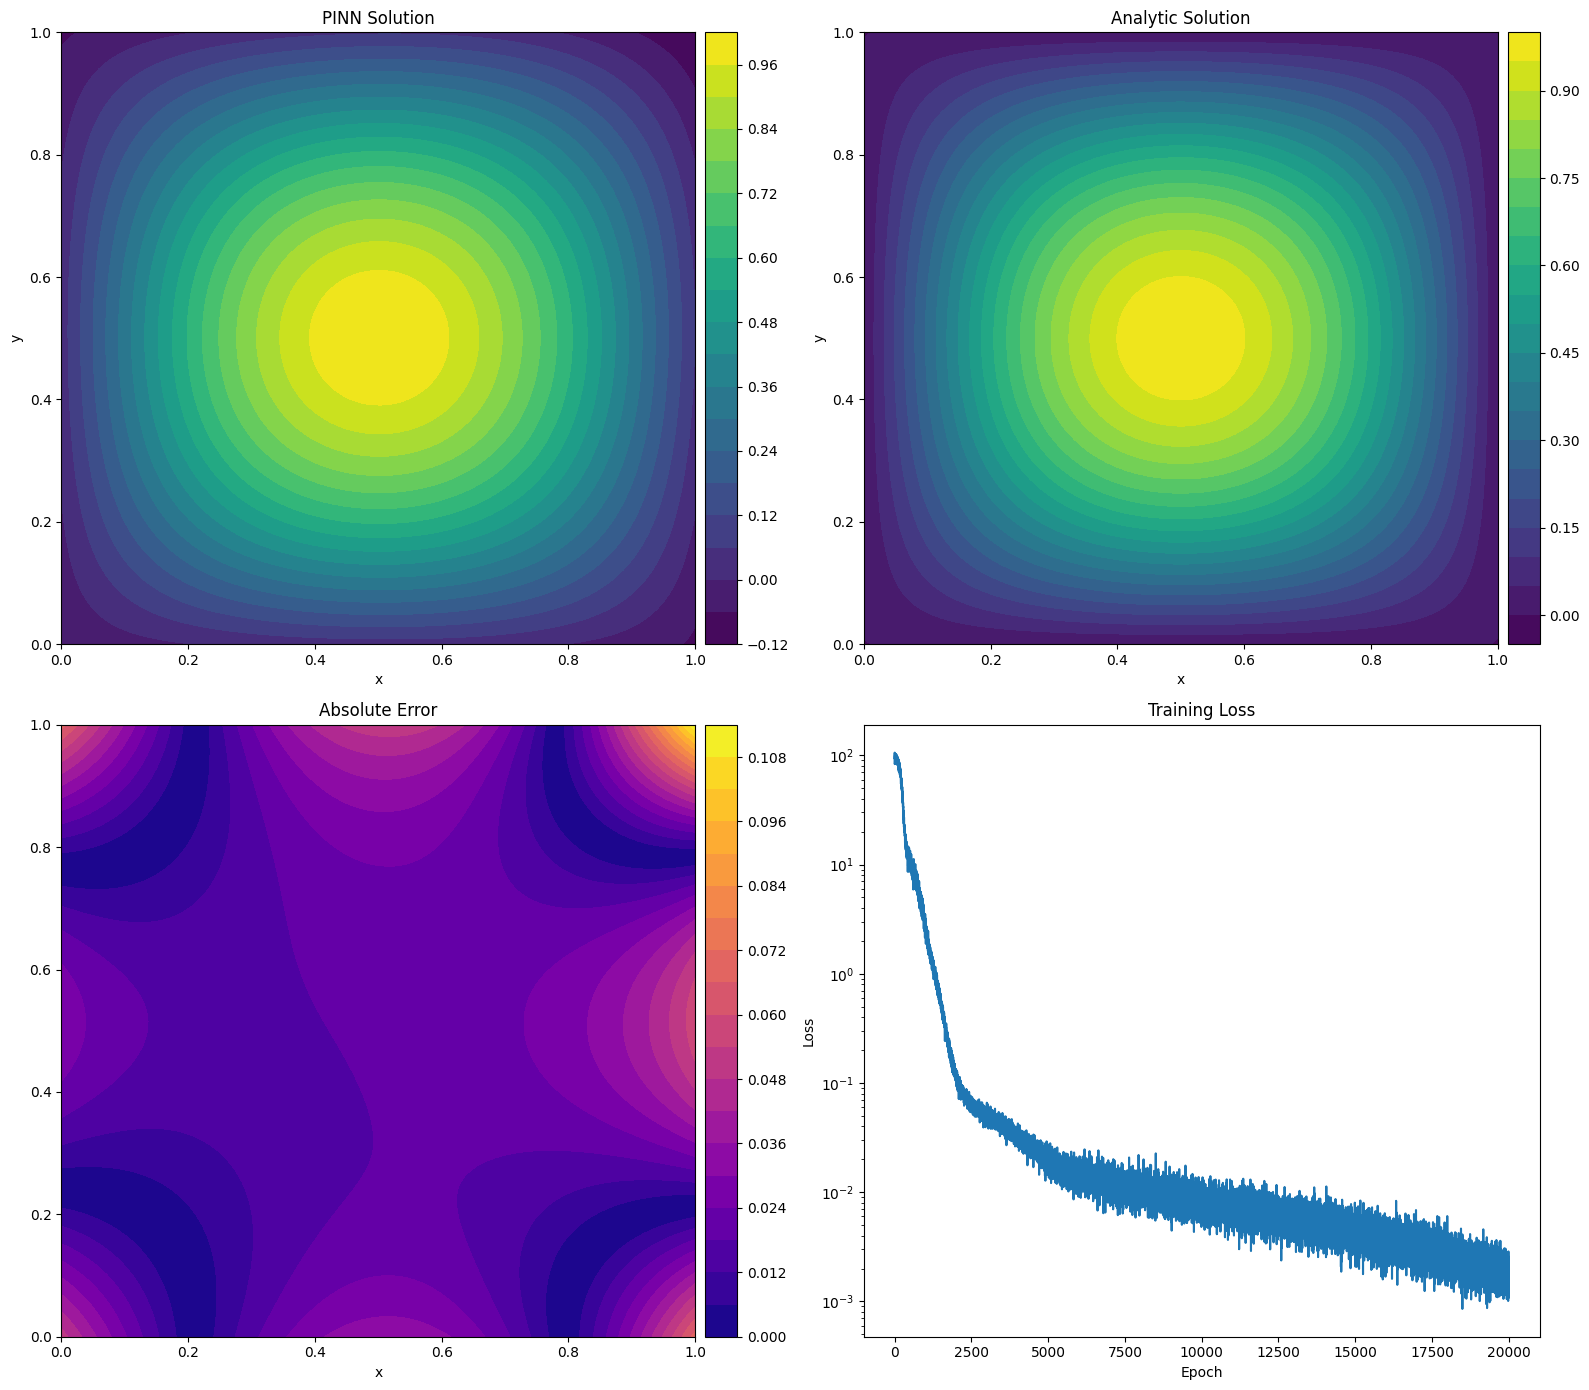

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

torch.manual_seed(42)
np.random.seed(42)

def poisson_eq_analytic(x, y):
    """解析解: u(x,y) = sin(πx)sin(πy)"""
    return torch.sin(np.pi * x) * torch.sin(np.pi * y)

def source_term(x, y):
    """源项 f(x,y) = -2π²sin(πx)sin(πy)"""
    return -2 * np.pi**2 * torch.sin(np.pi * x) * torch.sin(np.pi * y)

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.linear_layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.linear_layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.linear_layers.append(nn.Tanh())
    
    def forward(self, x):
        for layer in self.linear_layers:
            x = layer(x)
        return x

# 定义PINN的损失函数
def pinn_loss(net, x, y):
    """计算PINN的损失函数"""
    # 启用梯度计算
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    # 网络预测
    u = net(torch.cat([x, y], dim=1))
    
    # 计算一阶导数
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    
    # 计算二阶导数
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]
    
    # 泊松方程残差
    residual = u_xx + u_yy - source_term(x, y)
    
    # 在边界上的点应该有 u=0
    boundary_mask = (x == 0) | (x == 1) | (y == 0) | (y == 1)
    boundary_loss = u[boundary_mask].pow(2).mean()
    
    # 总损失 = 方程残差 + 边界条件
    loss = residual.pow(2).mean() + boundary_loss
    
    return loss

layers = [2, 50, 50, 50, 1]
lr = 1e-4
epochs = 20000
n_points = 100  # 每维采样点数

# 创建训练数据
x = torch.linspace(0, 1, n_points).view(-1, 1)
y = torch.linspace(0, 1, n_points).view(-1, 1)
X, Y = torch.meshgrid(x.squeeze(), y.squeeze())
X_flat = X.reshape(-1, 1)
Y_flat = Y.reshape(-1, 1)

# 初始化网络和优化器
net = PINN(layers)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# 训练
loss_history = []
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # 随机采样训练点
    idx = np.random.choice(len(X_flat), size=512, replace=False)
    x_train = X_flat[idx].clone().requires_grad_(True)
    y_train = Y_flat[idx].clone().requires_grad_(True)
    
    loss = pinn_loss(net, x_train, y_train)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4e}')

# 预测结果
with torch.no_grad():
    u_pred = net(torch.cat([X_flat, Y_flat], dim=1)).reshape(n_points, n_points)
    u_analytic = poisson_eq_analytic(X, Y)

error = torch.abs(u_pred - u_analytic)

fig = plt.figure(figsize=(16, 14))

# 子图1: PINN预测结果
ax1 = fig.add_subplot(221)
contour1 = ax1.contourf(X.numpy(), Y.numpy(), u_pred.numpy(), levels=20, cmap=cm.viridis)
ax1.set_title('PINN Solution')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(contour1, cax=cax)

# 子图2: 解析解
ax2 = fig.add_subplot(222)
contour2 = ax2.contourf(X.numpy(), Y.numpy(), u_analytic.numpy(), levels=20, cmap=cm.viridis)
ax2.set_title('Analytic Solution')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(contour2, cax=cax)

# 子图3: 误差
ax3 = fig.add_subplot(223)
contour3 = ax3.contourf(X.numpy(), Y.numpy(), error.numpy(), levels=20, cmap=cm.plasma)
ax3.set_title('Absolute Error')
ax3.set_xlabel('x')
ax2.set_ylabel('y')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(contour3, cax=cax)

# 子图4: 损失曲线
ax4 = fig.add_subplot(224)
ax4.semilogy(loss_history)
ax4.set_title('Training Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')

plt.tight_layout()
plt.show()